In [1]:
# imports
import io
import seaborn as sns
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
import numpy as np

import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
C:\Users\Lendl\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Read Datasets

In [2]:
# Read csv datasets
csv = "Data/owid-covid-data.csv"
df = pd.read_csv(csv, parse_dates=True, infer_datetime_format=True)

csv2 = "Data/world_country_and_usa_states_latitude_and_longitude_values.csv"
lat_df = pd.read_csv(csv2, parse_dates=True, infer_datetime_format=True)
lat_df.rename(columns={"country":"location"},inplace=True)

# Import the CSVs to Pandas DataFrames
file_path_2 = Path("Data/COVID19_Impact_on_Global_GDP.csv")
GDP_data = pd.read_csv(file_path_2, index_col='Year')

file_path_3 = Path('Data/Labour_Market_stats.csv')
Labour_Market_stats = pd.read_csv(file_path_3, index_col='Time')

file_path_4 = Path("Data/COVID19_Impact_per_Measure.csv")
Impact_per_Measure = pd.read_csv(file_path_4, index_col="Years")

#Google Mobility Data
google = Path("Data/Global_Mobility_Report.csv")
google_df = pd.read_csv(google, parse_dates=True, infer_datetime_format=True)

# Apple Mobility Data
apple = Path("Data/applemobilitytrends-2021-06-24.csv")
df2 = pd.read_csv(apple)

# Load API Key

In [3]:
# Read the Mapbox API key
load_dotenv(find_dotenv())
map_box_api = os.getenv("MAPBOX_API")

# Set the Mapbox API
px.set_mapbox_access_token(map_box_api)

# Adjust Dataframes

### Covid Datasets

In [4]:
# Fetch data for only China, United Kingdom, Italy, United States, Canada, India, Brazil, Japan, Germany and France
china_data = df[df["location"] == "China"]
uk_data = df[df["location"] == "United Kingdom"]
italy_data = df[df["location"] == "Italy"]
us_data = df[df["location"] == "United States"]
canada_data = df[df["location"] == "Canada"]
india_data = df[df["location"] == "India"]
brazil_data = df[df["location"] == "Brazil"]
jap_data = df[df["location"] == "Japan"]
ger_data = df[df["location"] == "Germany"]
france_data = df[df["location"] == "France"]

# Concatenate the data and set date as index
covid_df = pd.concat(
    [china_data, 
     uk_data, 
     italy_data, 
     us_data, 
     canada_data, 
     india_data, 
     brazil_data, 
     jap_data, 
     ger_data, 
     france_data],
    join = "inner",
    axis="index"
)
covid_df['date'] = pd.to_datetime(covid_df['date'])

# Fill NaN with '0' value
covid_df.fillna(0, inplace=True)

# Define function to get vaccinated data for each country
def get_vax(location):
    vax = covid_df.get((covid_df["location"]==location))
    return vax

brazil_vax = get_vax("Brazil")
can_vax = get_vax("Canada")
china_vax = get_vax("China")
france_vax = get_vax("France")
ger_vax = get_vax("Germany")
india_vax = get_vax("India")
italy_vax = get_vax("Italy")
jap_vax = get_vax("Japan")
uk_vax = get_vax("United Kingdom")
us_vax = get_vax("United States")

# Concatenate into a vaccination dataframe
vax_df = pd.concat([
    brazil_vax,
    can_vax,
    china_vax,
    france_vax,
    ger_vax,
    india_vax,
    italy_vax,
    jap_vax,
    uk_vax,
    us_vax,
], join="inner", axis=0
)
vax_df = vax_df.replace(0, np.nan)

# Isolate total cases for each country
def get_cases(location):
    cases = covid_df.get((covid_df["location"]==location))
    cases = pd.DataFrame(cases.get(["total_cases","date","new_cases"])).set_index("date")
    return cases

can_cases = get_cases("Canada").rename(columns={"total_cases":"can_cases", "new_cases":"new_can_cases"})
china_cases = get_cases("China").rename(columns={"total_cases":"china_cases", "new_cases":"new_china_cases"})
uk_cases = get_cases("United Kingdom").rename(columns={"total_cases":"uk_cases", "new_cases":"new_uk_cases"})
us_cases = get_cases("United States").rename(columns={"total_cases":"us_cases", "new_cases":"new_us_cases"})
italy_cases = get_cases("Italy").rename(columns={"total_cases":"italy_cases", "new_cases":"new_italy_cases"})
india_cases = get_cases("India").rename(columns={"total_cases":"india_cases", "new_cases":"new_india_cases"})
brazil_cases = get_cases("Brazil").rename(columns={"total_cases":"brazil_cases", "new_cases":"new_brazil_cases"})
jap_cases = get_cases("Japan").rename(columns={"total_cases":"jap_cases", "new_cases":"new_jap_cases"})
ger_cases = get_cases("Germany").rename(columns={"total_cases":"ger_cases", "new_cases":"new_ger_cases"})
france_cases = get_cases("France").rename(columns={"total_cases":"france_cases", "new_cases":"new_france_cases"})

# Concat into a dataframe
cases_df = pd.concat(
    [can_cases,
    china_cases,
    us_cases,
    uk_cases,
    india_cases,
    italy_cases,
    brazil_cases,
    jap_cases,
    ger_cases,
    france_cases],
    join="outer",
    axis="columns"
).fillna(0)

In [5]:
# Calculate the rolling 7-day average of new cases for each country
new_can_avg = (cases_df.get("new_can_cases")).rolling(7).mean()
new_china_avg = (cases_df.get("new_china_cases")).rolling(7).mean()
new_uk_avg = (cases_df.get("new_uk_cases")).rolling(7).mean()
new_us_avg = (cases_df.get("new_us_cases")).rolling(7).mean()
new_italy_avg = (cases_df.get("new_italy_cases")).rolling(7).mean()
new_india_avg = (cases_df.get("new_india_cases")).rolling(14).mean()
new_brazil_avg = (cases_df.get("new_brazil_cases")).rolling(7).mean()
new_jap_avg = (cases_df.get("new_jap_cases")).rolling(7).mean()
new_ger_avg = (cases_df.get("new_ger_cases")).rolling(7).mean()
new_france_avg = (cases_df.get("new_france_cases")).rolling(7).mean()

# Put rolling average into dataframe
avg_new_cases = pd.concat(
    [new_brazil_avg,
    new_can_avg,
    new_china_avg,
    new_france_avg,
    new_ger_avg,
    new_india_avg,
    new_italy_avg,
    new_jap_avg,
    new_uk_avg,
    new_us_avg],
    join="inner",
    axis=1
).reset_index()

In [6]:
# Create funtion to select countries needed.
def get_location(location):
    location = lat_df.get((lat_df["location"]==location))
    location = location.get(["latitude", "longitude", "location"])
    return location

# Get location of all countries needed
china_location = get_location("China")
uk_location = get_location("United Kingdom")
italy_location = get_location("Italy")
us_location = get_location("United States")
canada_location = get_location("Canada")
india_location = get_location("India")
brazil_location = get_location("Brazil")
jap_location = get_location("Japan")
ger_location = get_location("Germany")
france_location = get_location("France")

# Concat coordinates into a dataframe
country_location = pd.concat(
    [china_location, 
    uk_location,
    italy_location,
    us_location,
    canada_location,
    india_location,
    brazil_location,
    jap_location,
    ger_location,
    france_location],
    join="inner",
    axis="index"
).set_index("location")

In [7]:
# Create function to get the max total cases and max total death
def get_max(country):
    max_data = covid_df[covid_df["location"] == country].max()
    max_cases_death = pd.DataFrame(max_data.get(
        ["location",
         "total_cases",
         "total_deaths", 
         "people_vaccinated"]
    )).transpose()
    return max_cases_death

# Get max data for all countries
china_max = get_max("China")
uk_max = get_max("United Kingdom")
italy_max = get_max("Italy")
us_max = get_max("United States")
canada_max = get_max("Canada")
india_max = get_max("India")
brazil_max = get_max("Brazil")
jap_max = get_max("Japan")
ger_max = get_max("Germany")
france_max = get_max("France")

# Concatenate max data
country_max_cases = pd.concat(
    [china_max,
     uk_max,
     italy_max,
     us_max,
     canada_max,
     india_max,
     brazil_max,
     jap_max,
     ger_max,
     france_max
    ],
    join="inner",
    axis="index"
).set_index("location")

In [8]:
# Concatenate coordinates and cases dataframe
map_data = pd.concat(
    [country_max_cases,
    country_location
    ],
    join="inner",
    axis="columns"
)
map_data = map_data.astype("float64").reset_index()

### Mobility Datasets

In [9]:
# Rename Columns in dataframe
df_tidy = google_df.rename(columns = {'country_region': 'Country', 'retail_and_recreation_percent_change_from_baseline': 'Retail and Recreation', 
                               'grocery_and_pharmacy_percent_change_from_baseline': 'Grocery and Pharmacy', 
                               'parks_percent_change_from_baseline': 'Parks', 'transit_stations_percent_change_from_baseline': 
                               'Transit Stations', 'workplaces_percent_change_from_baseline': 'Workplaces', 
                               'residential_percent_change_from_baseline': 'Residential'}, inplace = False)

# Create a list and query of countries for analysis
list_countries = ['Brazil', 'Canada', 'France','Germany', 'India', 'Italy', 'Japan', 'United States', 'United Kingdom']
countries = df_tidy.query('Country in @list_countries')

# Change index for apple dataset
df2 = df2.set_index(['region','transportation_type']).transpose()
df2.drop(df2.index[:4], inplace=True)
df2.index = pd.to_datetime(df2.index)
df2.bfill(inplace=True)
apple_df = df2

### GDP Datasets

In [10]:
# Adjust dataset
Labour_Market_stats.drop(columns=['France','Germany','Italy','Japan','United Kingdom','United States'],inplace=True)

GDP_data2 = pd.read_csv(file_path_2)

# Functions

### Mobility Functions

In [11]:
# Median Increase in Residential Activities
def residential_median(data, title, xlabel, ylabel, color):
    """
    Residential Activities
    """
    
    fig = plt.figure()
    sns.distplot(data[ylabel]) 
    plt.title(title +str(np.nanmedian(df_tidy[ylabel])))
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    
    plt.close()
    return pn.pane.Matplotlib(fig, tight=True)

# Percentage Change in Retail, Recreation, Workplaces and Transit Stations
def change_in_mobility(data, title, xlabel, ylabel1, ylabel2, ylabel3, ylabel4, ylabel5, ylabel6):
    """
    2020 to 2021 Mobility: Percentage Change
    """
    fig ,axes = plt.subplots(4, 1, sharex=True, sharey=False)
    figure_data = data[data[ylabel1].isnull()][[ylabel2,ylabel3,ylabel4,ylabel5,ylabel6]].groupby(ylabel2).rolling(7).mean().groupby(ylabel2).last().sort_values(by=ylabel3)
   
    Retail =sns.barplot(ax=axes[0], x=figure_data.index, y=figure_data['Retail and Recreation'])
    axes[0].set_title('Retail and Recreation')
    Retail.set(xlabel=None)
    Retail.set(ylabel=None)
    
    
    Workplaces= sns.barplot(ax=axes[1], x=figure_data.index, y=figure_data['Workplaces'])
    axes[1].set_title('Workplaces')
    Workplaces.set(xlabel=None)
    Workplaces.set(ylabel=None)
    

    Transit=sns.barplot(ax=axes[2], x=figure_data.index, y=figure_data['Transit Stations'])
    axes[2].set_title('Transit Stations')
    Transit.set(xlabel=None)
    Transit.set(ylabel=None)
    
    Grocery=sns.barplot(ax=axes[3], x=figure_data.index, y=figure_data['Grocery and Pharmacy'])
    axes[3].set_title('Grocery and Pharmacy')
    Grocery.set(xlabel=None)
    Grocery.set(ylabel=None)
    
    plt.close()
    return pn.pane.Matplotlib(fig,tight=True)

# Apple Commute
def change_in_commute(data, ylabel):
    "Changes in Day to Day Commute"
    
    fig = plt.figure()
    sns.lineplot(data=data[[ylabel]].loc[:,(slice(None),'driving')].rolling(7).mean())
    
    plt.close()
    return pn.pane.Matplotlib(fig, tight=True)



### GDP Functions

In [12]:
#Panel Visualization Functions
def GDP_per_Capita():
    """GDP per Capita"""
    Per_Capita = ['GDP per Capita']
    GDP_data.hvplot.bar('Year',
                   Per_Capita,groupby='Country',
                   rot=90,
                   stacked=False,
                   xlabel='Years',
                   ylabel='GDP per Capita: in U.S. dollars',
                   width=700, 
                   height=400,
                   shared_axes=False)

    return GDP_data

def GDP_per_Country():
    """
    Create a line chart based on GDP per Country.
    """ 
    
    GDP_data2.hvplot.line(x='Year',y='GDP',groupby='Country')  
    return GDP_data2

def GDP_Growth_Rate_per_Country():
    """
    Create a barplot based in the data argument for GDP Growth Rate per Country. 
    """
    
    Country_Lists = ['China','Japan','Brazil','Canada','United States','United Kingdom','Italy','India','France','Germany']
    Impact_per_Measure.hvplot.bar('Years',
                   Country_Lists,groupby='Measures',
                   rot=90,
                   stacked=False,
                   xlabel='Country',
                   ylabel='Percentage GDP Growth Rate',
                   width=1400, 
                   height=700,
                   shared_axes=False).opts(axiswise=True)
    return Impact_per_Measure


def  Covid_19_effect_on_Global_Employment():
    """Covid-19 effect on Global Employment, comparing Canada, G7,Euro Area and European Union.""" 
    Labour_Market_stats.hvplot(x='Time', y=['Canada', 'G7', 'OECD_Total','Euro_Area_19','European_Union_27'],
             value_label='Employment Rate (Percentage of Population)',
             width=800,
             height=500,
             title='Covid-19 effect on Global Employment')
    return Labour_Market_stats


# Plot Charts

### Covid Plots

In [13]:
# Plot the data to see a country's vaccination data compared the country's cases
vax_cases_plot = vax_df.hvplot(
    y=["people_vaccinated","people_fully_vaccinated","total_cases"],
    groupby="location",
    value_label = "Amount",
    title="Vaccinations vs Covid-19 Cases",
    height=400,
    width=700
)

In [14]:
# Plot data for total cases
cases_plot = cases_df.hvplot(
    x="date",
    y=[
        "brazil_cases",
        "can_cases",
        "china_cases",
        "france_cases",
        "ger_cases",
        "india_cases",
        "italy_cases",
        "jap_cases",
        "uk_cases",
        "us_cases",
    ],
    value_label="Number of Cases",
    title="Total Cases",
    height=400,
    width=700
)


In [15]:
# Slice and plot data by name
global_map = px.scatter_mapbox(
    map_data,
    lon="longitude",
    lat="latitude",
    color="total_cases",
    size="total_cases",
    zoom=0.5,
    hover_name="location",
    hover_data=["total_deaths", "people_vaccinated"],
    title="Covid-19 Cases/Deaths/Vaccinations",
    height=600,
    width=900
)

### Mobility Panes

In [36]:
# Line chart function to be added to pn.pane function
Canada = change_in_commute(apple_df, 'Canada')
UK = change_in_commute(apple_df, 'United Kingdom')
Italy = change_in_commute(apple_df, 'Italy')
Japan = change_in_commute(apple_df, 'Japan')
India = change_in_commute(apple_df, 'India')
Brazil = change_in_commute(apple_df, 'Brazil')
Germany = change_in_commute(apple_df, 'Germany')
France = change_in_commute(apple_df, 'France')
US = change_in_commute(apple_df, 'United States')

countries_1 = pn.Row(Brazil, Canada)
countries_2 = pn.Row(France, Germany)
countries_3 = pn.Row(India, Italy)
countries_4 = pn.Row(Japan, UK)
countries_5 = pn.Row(US)

countries_combined = pn.Column(countries_1, countries_2, countries_3, countries_4, countries_5)


### GDP Plots

In [17]:
#Bar Chart functions (GDP per Capita and GDP Growth Rate per Country); Line Chart functions (GDP and Covid-19 effect on Global Employment)

#GDP per Capita 2016-2026
Per_Capita = ['GDP per Capita']
GDP_per_Capita= GDP_data.hvplot.bar('Year',
                   Per_Capita,groupby='Country',
                   rot=90,
                   stacked=False,
                   xlabel='Years',
                   ylabel='GDP per Capita: in U.S. dollars',
                   width=700, 
                   height=400, 
                   shared_axes=False)

In [18]:
#GDP per Country
GDP_per_Country=GDP_data2.hvplot.line(x='Year',y='GDP',groupby='Country')


In [19]:
#GDP Growth Rate per Country
GDP_Growth_rate= Impact_per_Measure.hvplot.bar('Years', ['China','Japan','Brazil','Canada','United States','United Kingdom','Italy','India','France','Germany'],
                   groupby='Measures',
                   rot=90,
                   stacked=False,
                   xlabel='Country',
                   ylabel='Percentage GDP Growth Rate',
                   width=1400, 
                   height=700)


In [48]:
#Covid-19 Impact On Global Employment
Covid_19_Employment = Labour_Market_stats.hvplot(x='Time', y=['Canada', 'G7', 'OECD_Total','Euro_Area_19','European_Union_27'],
                                value_label='Employment Rate (Percentage of Population)',
                                width=800,
                                height=500,
                                title='Covid-19 effect on Global Employment')

# Dashboarding

In [50]:
# Create a Title for the Dashboard
covid_dashboard = pn.GridSpec(sizing_mode='stretch_both') 
covid_dashboard = pn.Column('# The Impact of COVID-19 Pandemic on the Global Economy')

# Define a welcome text
welcome_text = pn.pane.Markdown(
    '### This project looks into the impact of Covid-19 on the global economy, with specific attention being placed on the worlds seven largest economies and Canada. Furthermore, we have taken a detailed look at how covid 19 have impacted: Global Gross Domestic Product, Global Mobility Changes and the benefits of Vaccinations administered.'
)

# Ready charts for dashboard
welcome_tab = pn.Column(welcome_text, global_map)
cases_vax_tab = pn.Row(cases_plot, vax_cases_plot)
residential_median_pn = pn.Column(residential_median(countries, 'Median Percentage Increase in Residential Areas : ', 
                                      'Median Values', 'Residential', 'blue'))
mobility_change_pn = pn.Column(change_in_mobility(countries, 'Mobility : Percentage Change', 'Countries', 'sub_region_1', 'Country', 'Retail and Recreation', 'Workplaces','Transit Stations', 'Grocery and Pharmacy'))
Covid_19_Employment_pn = pn.Column(Covid_19_Employment)                           
GDP_Indicators = pn.Column(GDP_per_Capita,GDP_Growth_rate,GDP_per_Country)

# Create a tab layout for the dashboard
tabs = pn.Tabs(
    ("Welcome", welcome_tab),
    ("Vaccination vs Cases", cases_vax_tab),
    ("Median Percentage Increase in Residential Areas", residential_median_pn),
    ("Mobility Change", mobility_change_pn),
    ("Driving 7-Day Rolling Averages", countries_combined),
    ("GDP Analysis", GDP_Indicators),
    ("Employment Rates", Covid_19_Employment_pn),
    width=1024,
    height=768
)

covid_dashboard.append(tabs)

Column
    [0] Markdown(str)
    [1] Tabs(height=768, sizing_mode='fixed', width=1024)
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Row
            [0] HoloViews(NdOverlay)
            [1] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='location', options=['Brazil', 'Canada', ...], value='Brazil', width=250)
                    [1] VSpacer()
        [2] Column
            [0] Matplotlib(Figure, tight=True)
        [3] Column
            [0] Matplotlib(Figure, tight=True)
        [4] Column
            [0] Row
                [0] Matplotlib(Figure, tight=True)
                [1] Matplotlib(Figure, tight=True)
            [1] Row
                [0] Matplotlib(Figure, tight=True)
                [1] Matplotlib(Figure, tight=True)
            [2] Row
                [0] Matplotlib(Figure, tight=True)
                [1] Matplotlib(Figure, tight=True)
            [3] Row
                [0] Matplotlib(Figure, tight=True)
                [1] Matplotlib(Figure, tight=True)
            [4] Row
                [0] Matplotlib(Figure, tight=True)
        [5] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='Country', options=['Japan', 'Brazil', ...], value='Japan', width=250)
                    [1] VSpacer()
            [1] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='Measures', options=['GDP Growth Rate', ...], value='GDP Growth Rate', width=250)
                    [1] VSpacer()
            [2] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='Country', options=['Japan', 'Brazil', ...], value='Japan', width=250)
                    [1] VSpacer()
        [6] Column
            [0] HoloViews(NdOverlay)
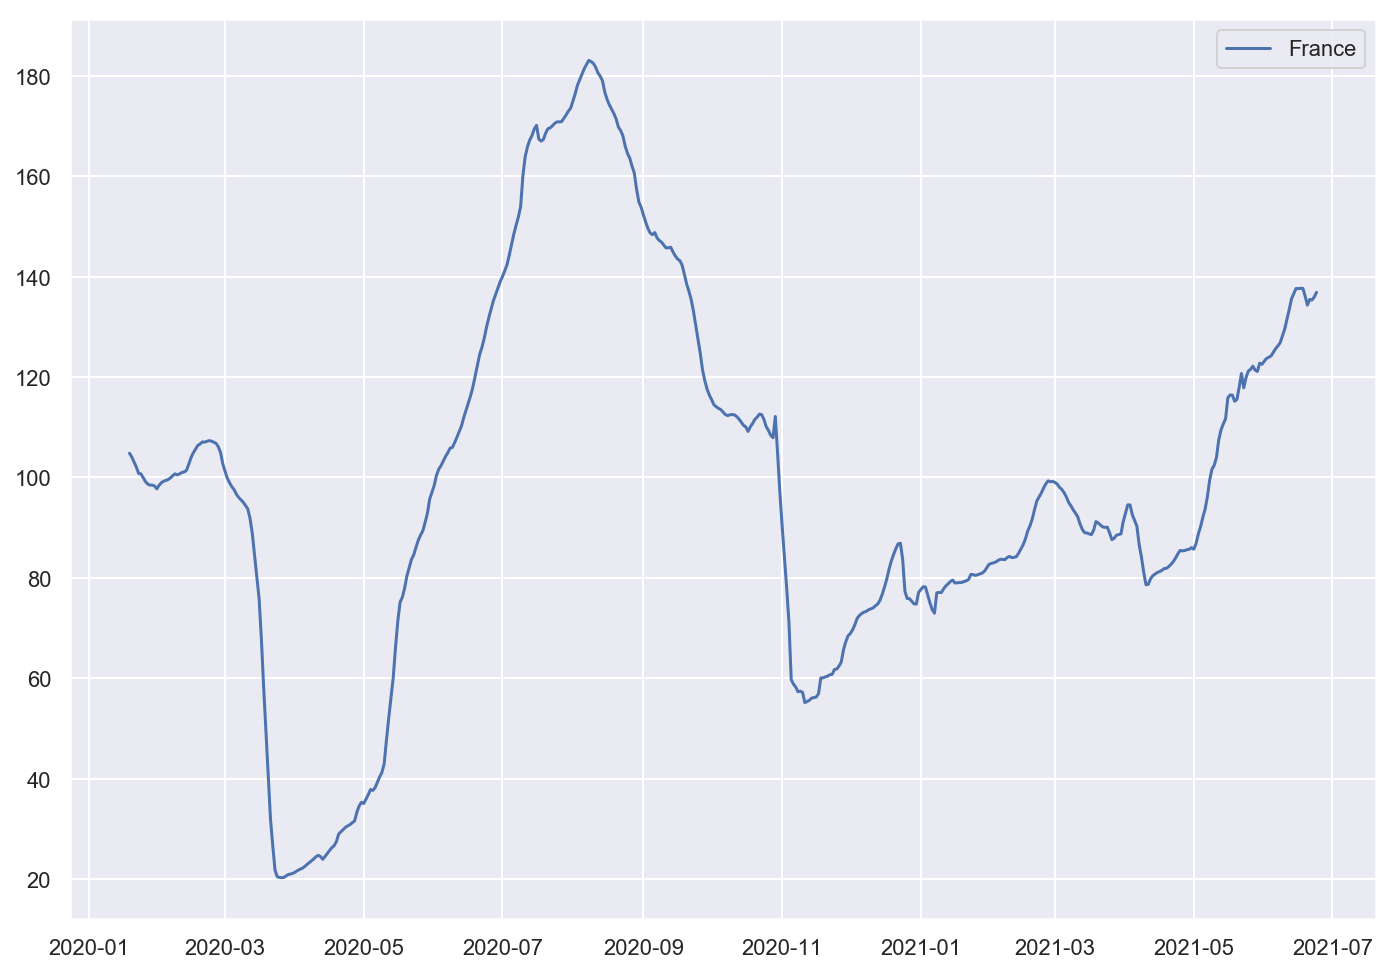
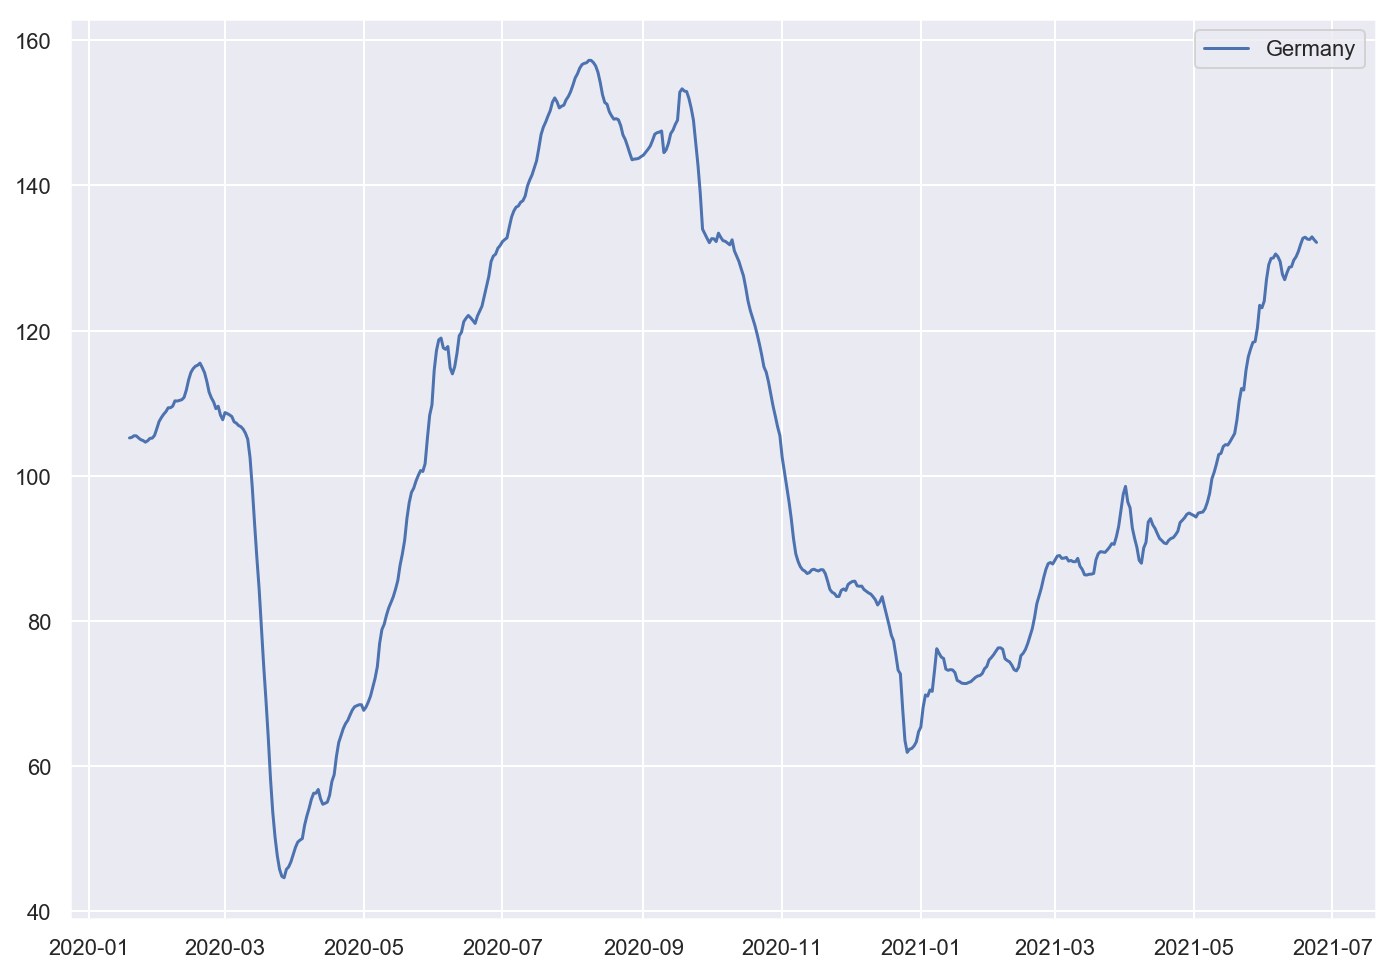
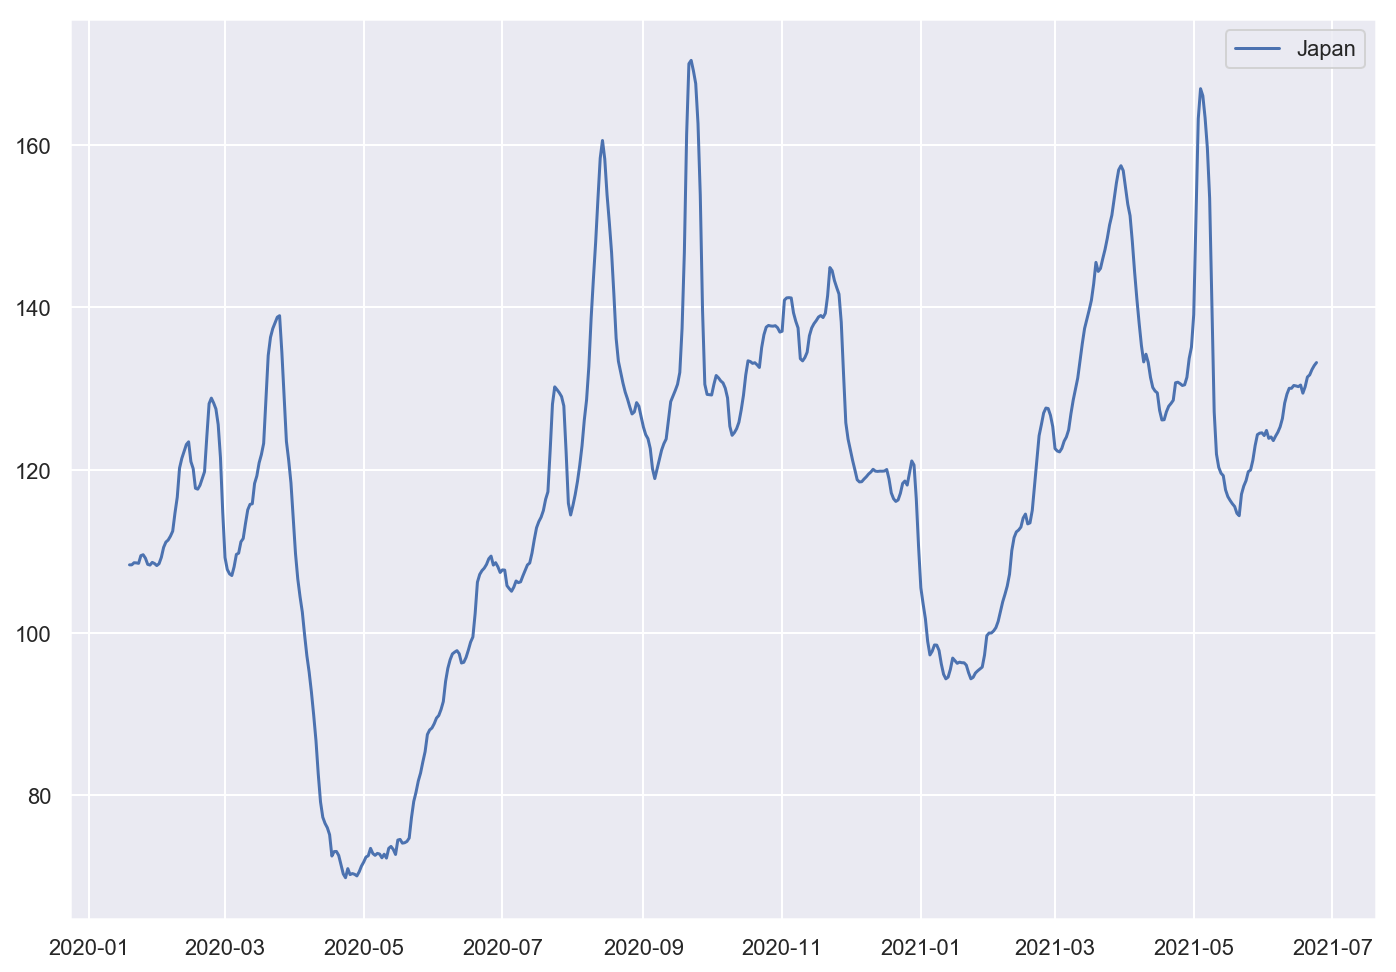
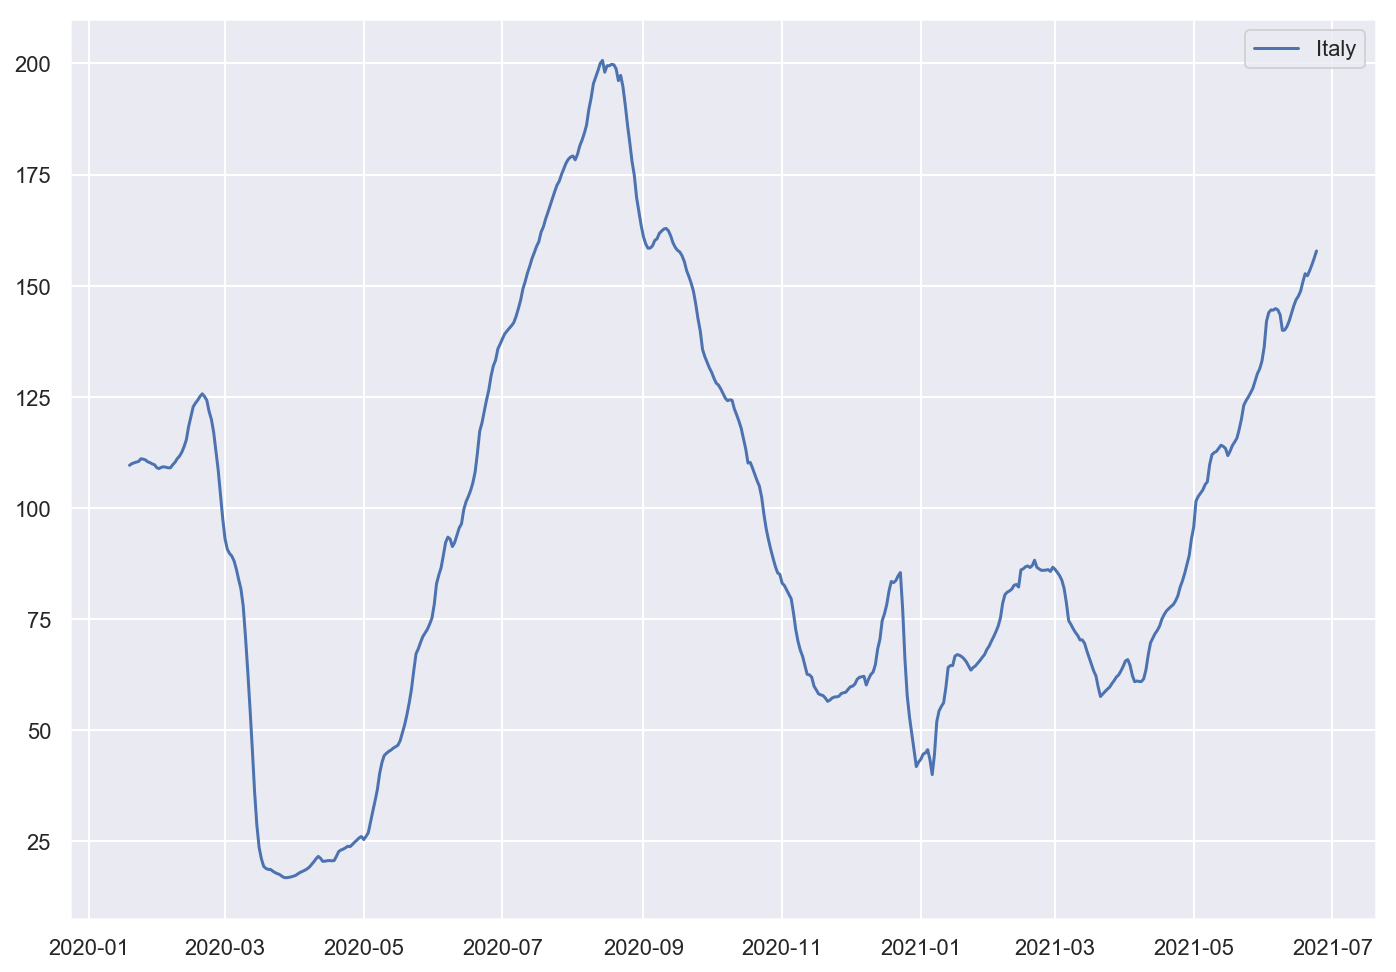
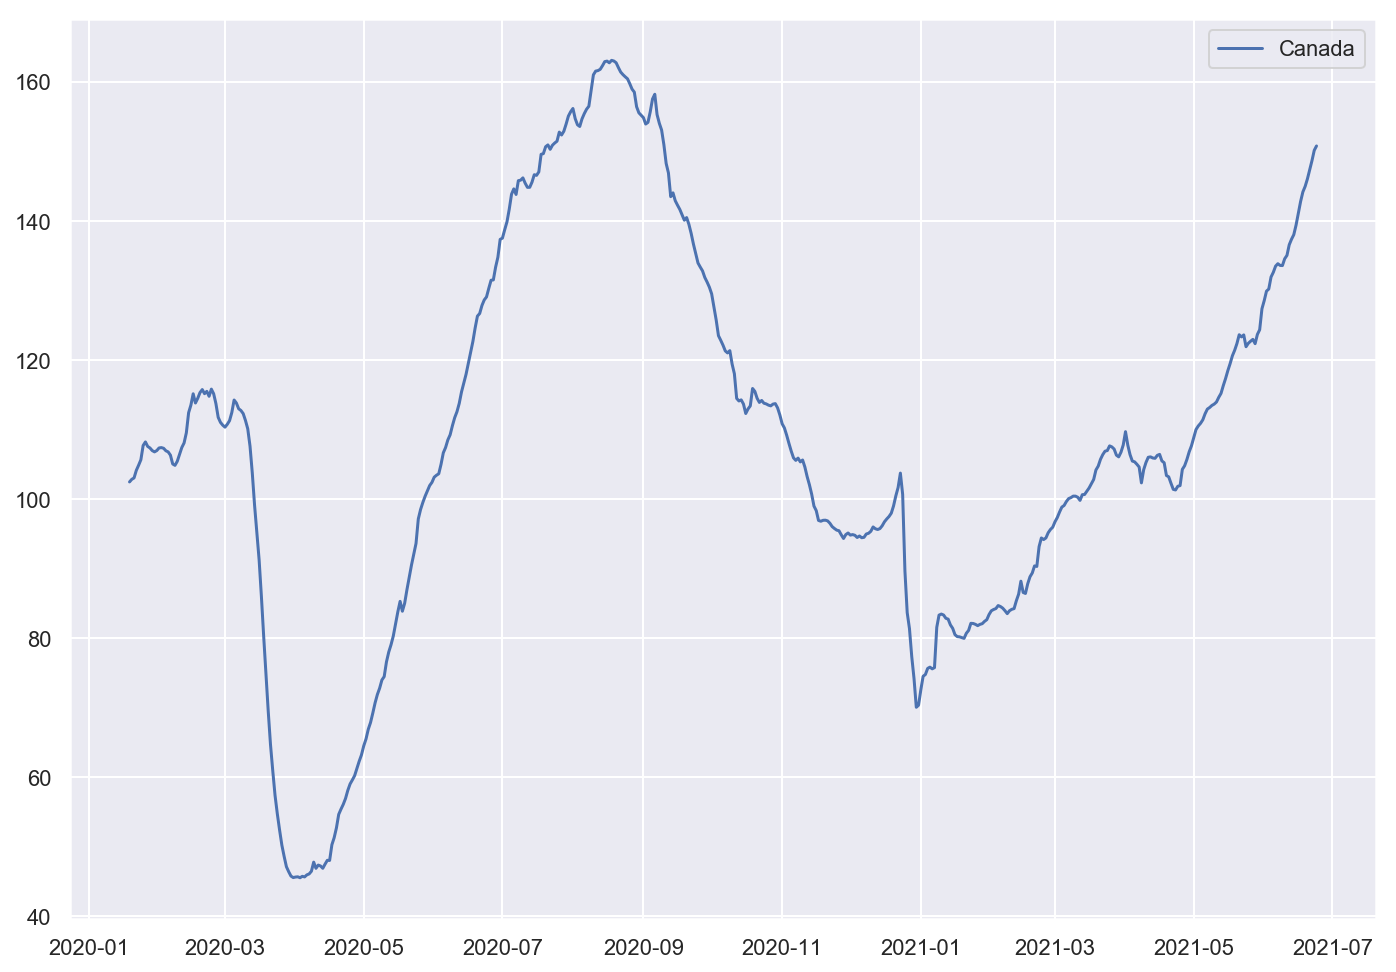
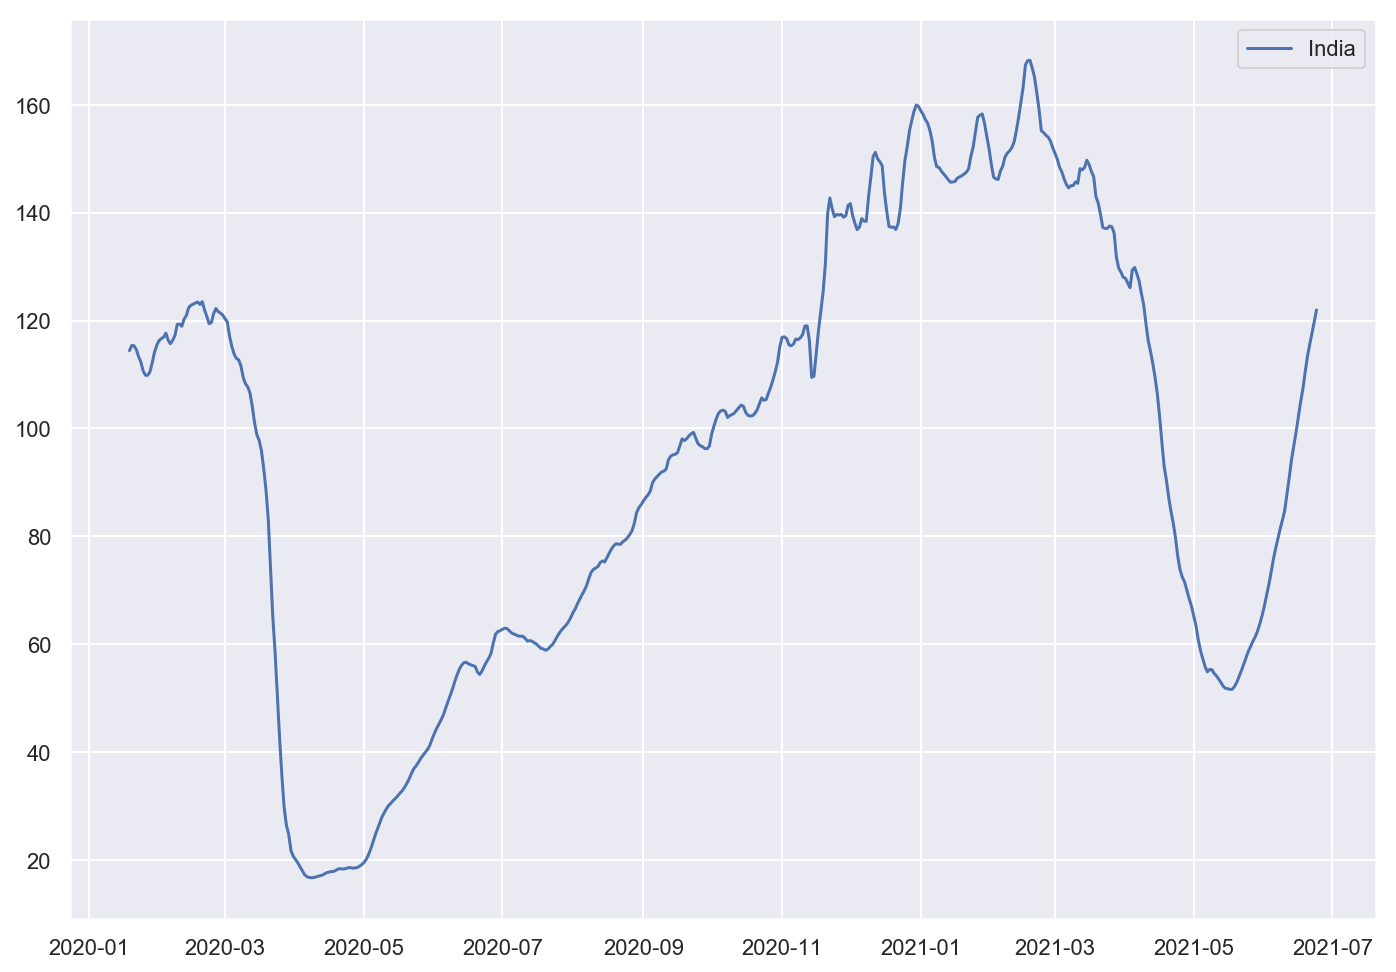
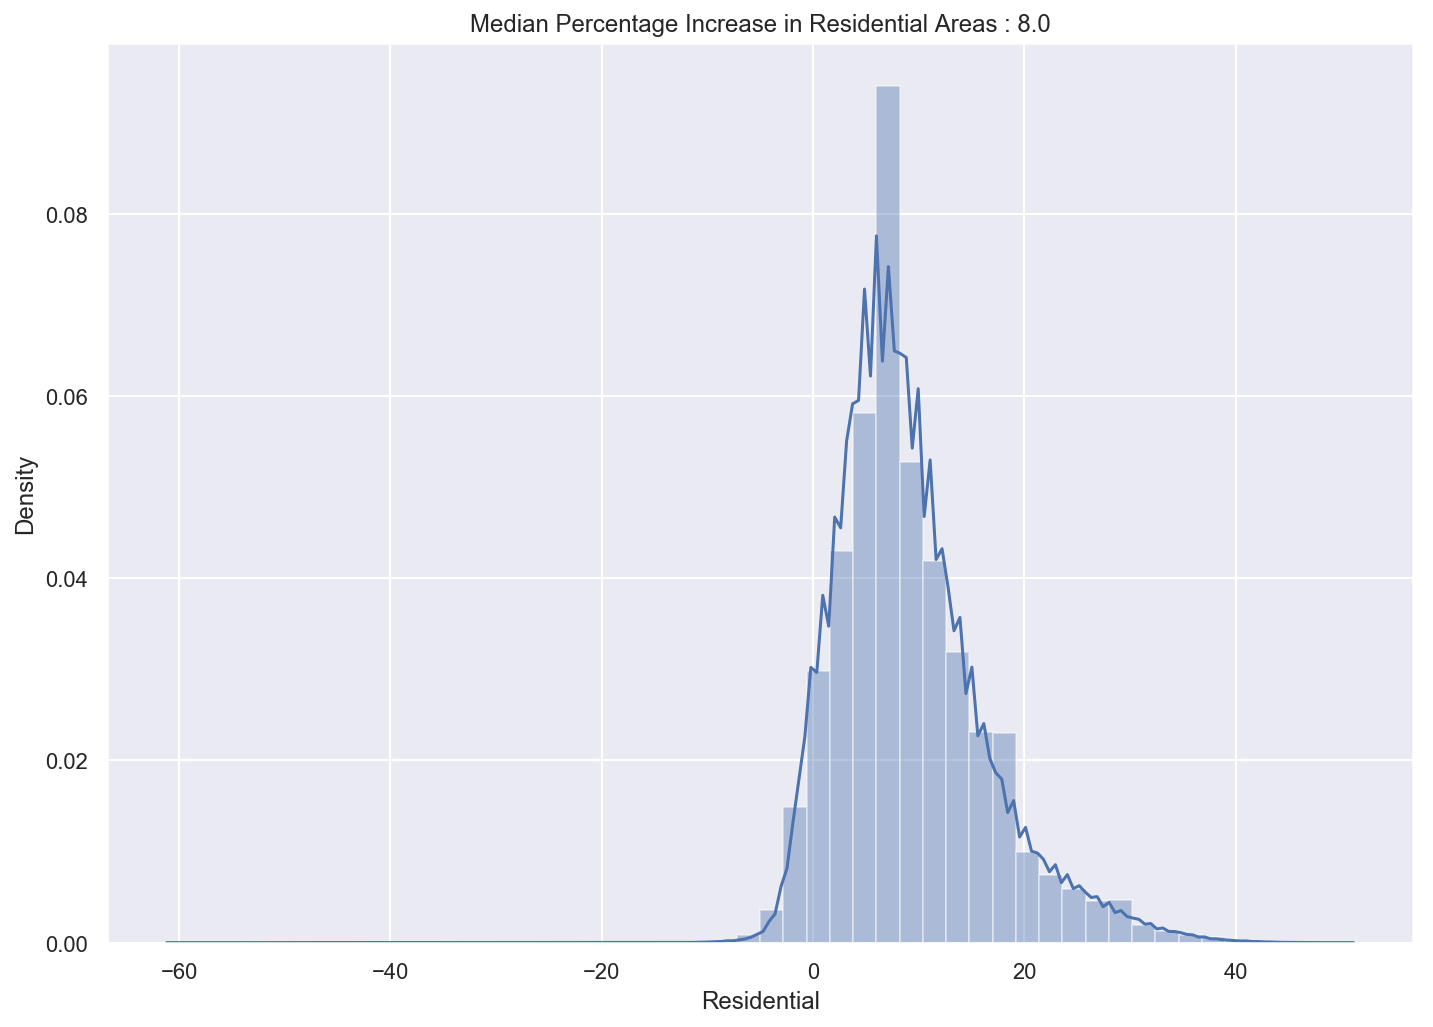
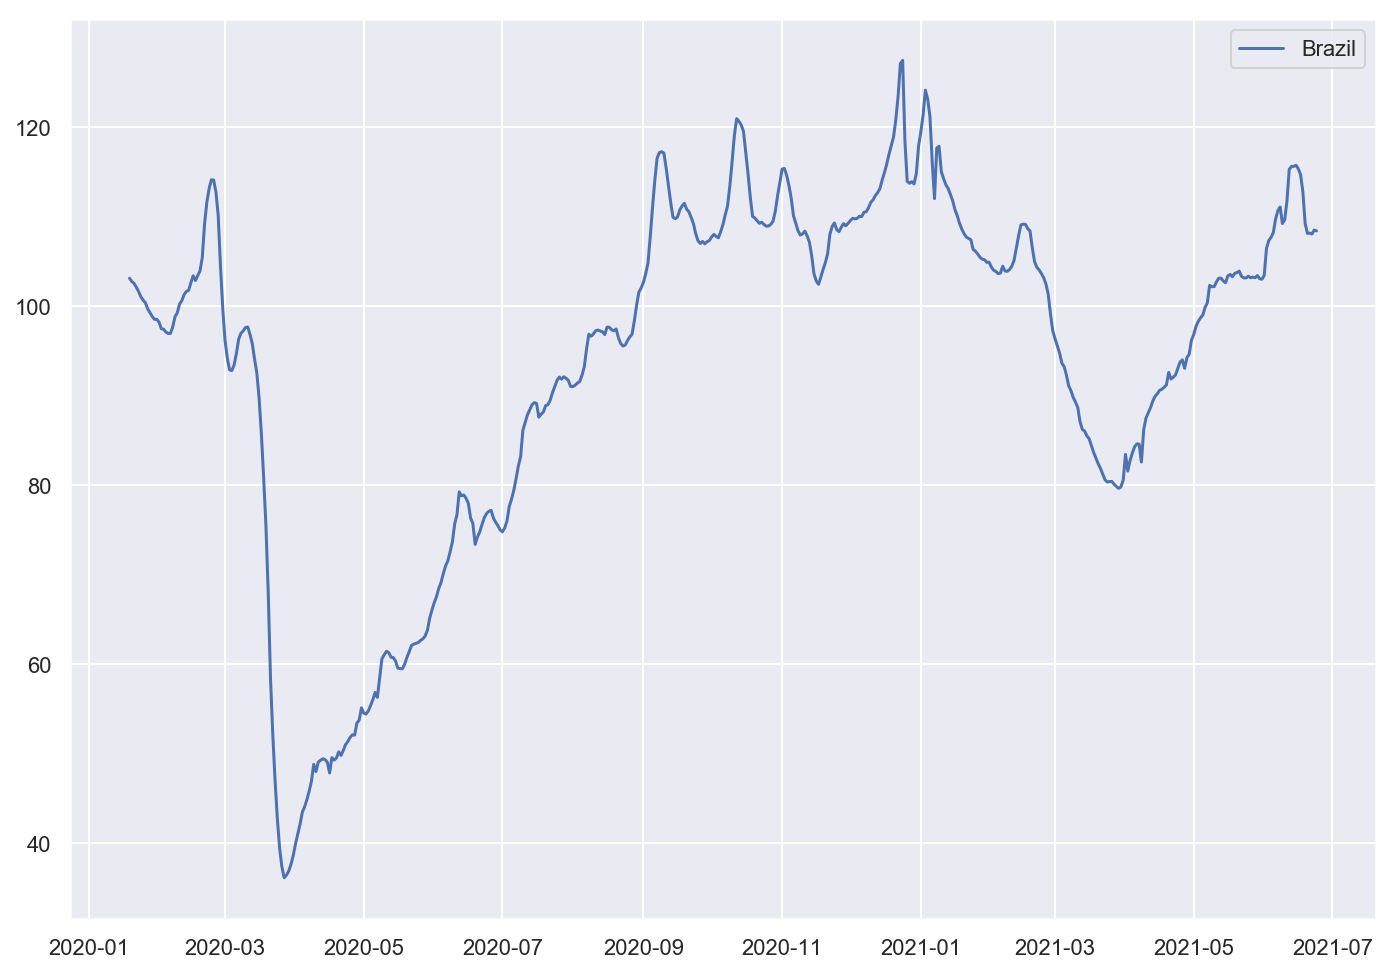
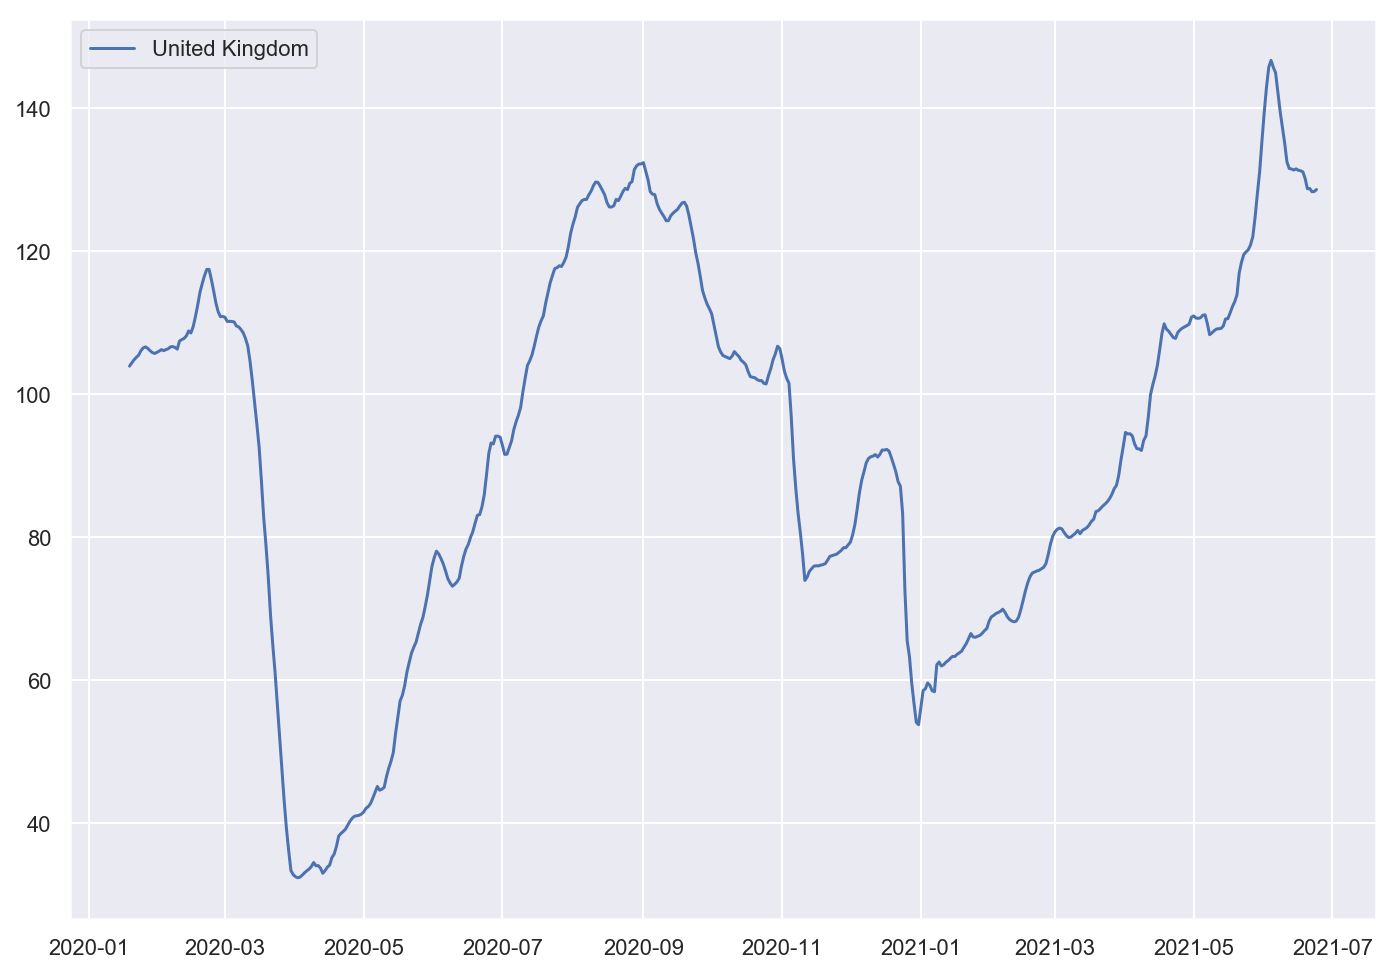
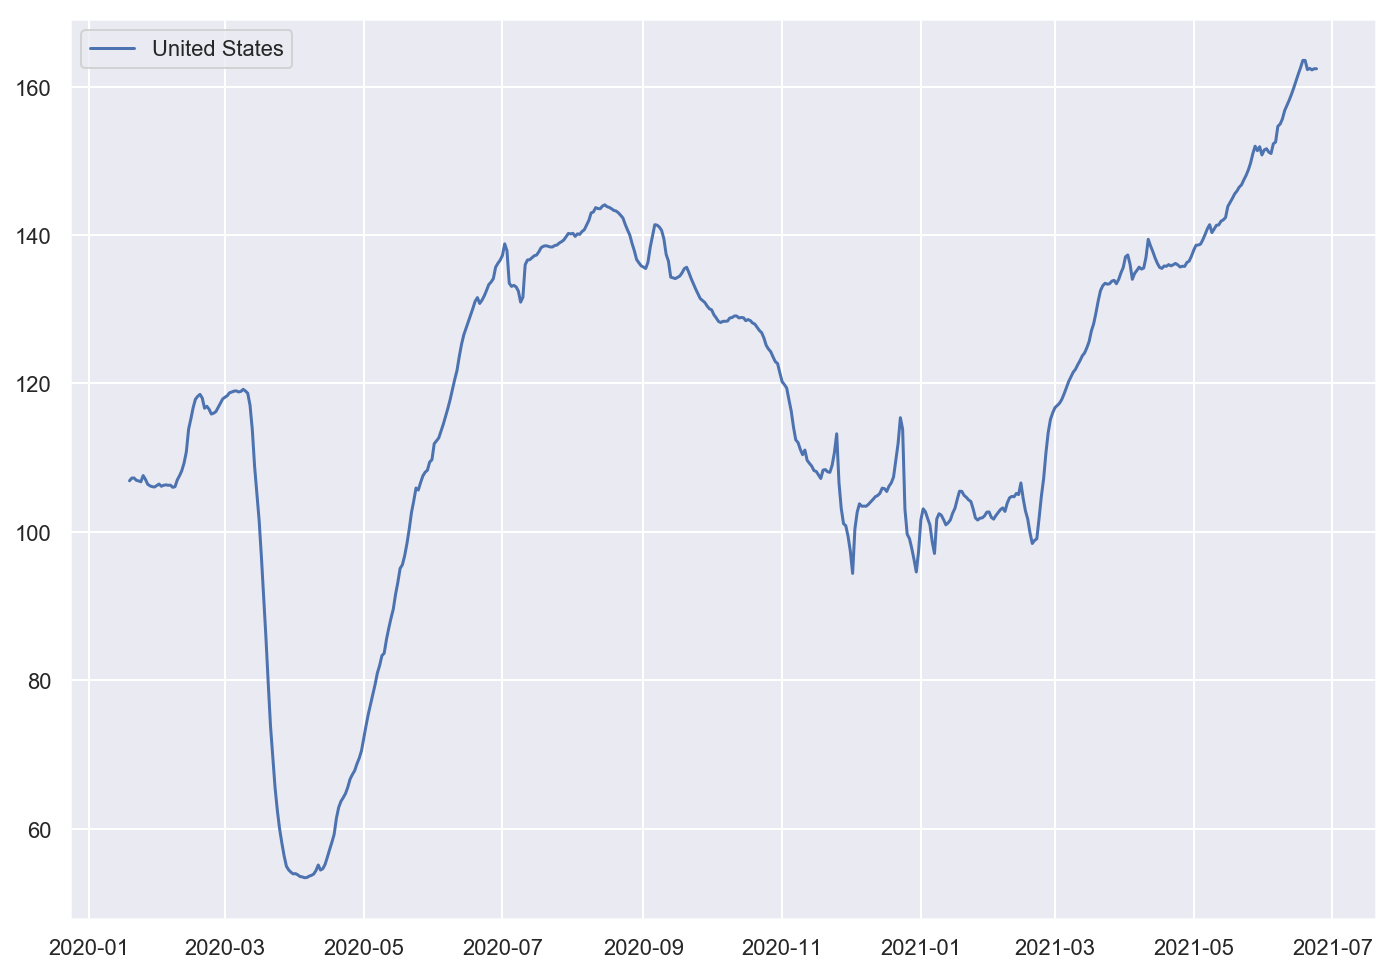
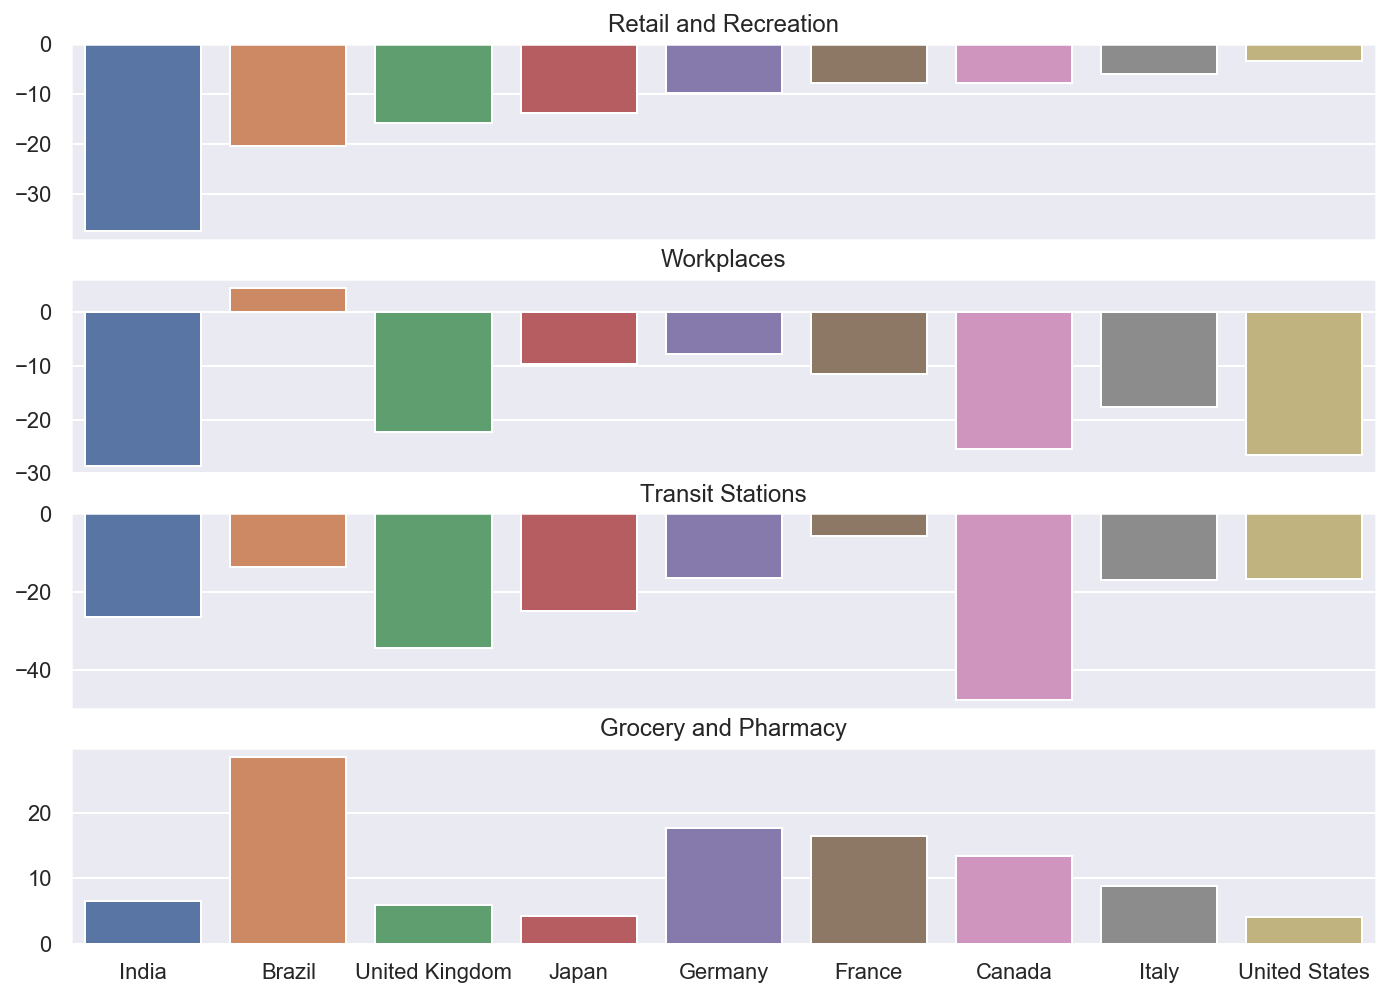

In [51]:
covid_dashboard.servable()